### 1. download data sets

Visit: https://www.kaggle.com/c/allstate-claims-severity/data <br\>
You need to accept the competition rules in order to download the datasets:
train.csv
test.csv

### 2. import packages

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import time
from copy import deepcopy
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

### 3. read data, and take a glance 

In [2]:
train = pd.read_csv('train.csv')
train  = train.iloc[:10000]               # Use only first 10000 obs to save time
test  = pd.read_csv('test.csv')
train.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


### 4. lexical encoding

In [3]:
test['loss'] = np.nan
data = pd.concat([train, test])

# lexical encoding (not recommended if the categorical feature is not ordinal)
categorical_list = list(data.select_dtypes(include=['object']).columns)
for column in categorical_list:
    data[column] = pd.factorize(data[column].values, sort=True)[0]

train  = data[data['loss'].notnull()]
train2 = deepcopy(train)                  # make a copy for later use 
del train2['id']
test   = data[data['loss'].isnull()]

test_id = test['id']
y_train = train['loss'] 
del train['id']
del train['loss'] 
del test['id']
del test['loss']

print(train.shape)      # X_train
print(test.shape)       # X_test
print(y_train.shape)    # y_train

print(np.mean(y_train)) # used as base_score

(10000, 130)
(125546, 130)
(10000,)
3051.6737099999978


### 5. tune parameters- approach 1: xgb.cv

In [4]:
X_y_train = xgb.DMatrix(data=train, label=y_train)
X_test    = xgb.DMatrix(data=test)
params_recorder_1 = None

In [5]:
params = {
          'base_score': np.mean(y_train),
          'eta':  0.1,
          'max_depth': 3,
          'colsample_bytree': 0.5,
          'subsample': 0.8,
          'lambda': 1.3,
          'gamma': 1,
          'seed': 2017,
          #'updater':'grow_gpu_hist',
          'tree_method' :'exact',
          'objective'   :'reg:linear',
          'eval_metric' :'mae'
         }

In [6]:
start_time = time.time()
cv_table = xgb.cv(params=params,  
                  dtrain=X_y_train, 
                  num_boost_round=10000,
                  nfold=5,
                  verbose_eval = 20,
                  early_stopping_rounds = 30,
                  seed =1)
print("--- %s seconds ---" % (time.time() - start_time))

[0]	train-mae:1907.86+5.96609	test-mae:1908.83+21.5043
[20]	train-mae:1429.9+9.29395	test-mae:1456.07+22.0001
[40]	train-mae:1320.57+8.03141	test-mae:1366.13+23.0444
[60]	train-mae:1264.1+5.9823	test-mae:1326.81+23.5624
[80]	train-mae:1229.47+7.45791	test-mae:1305.89+21.7106
[100]	train-mae:1206.98+6.42537	test-mae:1296.51+21.6393
[120]	train-mae:1190.52+5.94235	test-mae:1290.81+22.1462
[140]	train-mae:1176.32+5.84342	test-mae:1287.3+22.0488
[160]	train-mae:1163.7+5.94239	test-mae:1283.91+20.7422
[180]	train-mae:1151.89+6.24439	test-mae:1283.46+21.3179
[200]	train-mae:1142.26+5.91662	test-mae:1282.76+22.0854
--- 15.527958154678345 seconds ---


#### record parameters

In [7]:
params2 = {}
for item in params:
    params2[item] = [params[item]]
observation = pd.DataFrame(params2)
observation['round'] =  cv_table.shape[0]
observation['CV_error'] =  cv_table.iloc[cv_table.shape[0]-1][cv_table.columns[0]]
observation['Train_error'] =  cv_table.iloc[cv_table.shape[0]-1][cv_table.columns[2]]

displayed_columns = ['eta', 'max_depth', 'gamma', 'lambda', 'colsample_bytree', 'subsample',
                     'base_score', 'seed', 'round', 'eval_metric', 'CV_error', 'Train_error']
observation = observation[displayed_columns]
observation.columns = ['eta', 'max_d', 'gamma', 'lambda', 'colsample', 'subsample',
                       'base', 'seed', 'round', 'eval','CV_error', 'Train_error']

observation.head()

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,CV_error,Train_error
0,0.1,3,1,1.3,0.5,0.8,3051.67371,2017,172,mae,1282.350562,1156.857642


In [8]:
params_recorder_1 = pd.concat([params_recorder_1, observation])
params_recorder_1.head(20)

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,CV_error,Train_error
0,0.1,3,1,1.3,0.5,0.8,3051.67371,2017,172,mae,1282.350562,1156.857642


#### build predictive models

In [9]:
model = xgb.train(params=params,  
                  dtrain=X_y_train, 
                  num_boost_round=215)

### 5. tune parameters- approach 2: watch list

In [10]:
params_recorder_2 = None

train, valid = train_test_split(train2, test_size = 0.2, random_state = 42)
y_train = train['loss']
y_valid = valid['loss']
del train['loss']
del valid['loss']

DM_train = xgb.DMatrix(data=train, label=y_train)
DM_valid = xgb.DMatrix(data=valid, label=y_valid)
watchlist = [(DM_train, 'train'), (DM_valid, 'valid')]

In [11]:
params = {
          'base_score': np.mean(y_train),
          'eta':  0.1,
          'max_depth': 4,
          'colsample_bytree': 0.7,
          'subsample': 0.7,
          'lambda': 1.3,
          'gamma': 1.2,
          'seed': 2017,
          'tree_method' :'exact',
          'objective'   :'reg:linear',
          'eval_metric' :'mae'
         }

model  = xgb.train(params=params,  
                   dtrain=DM_train, 
                   num_boost_round=10000,
                   evals=watchlist,
                   early_stopping_rounds=50,
                   verbose_eval=20
                  )

[0]	train-mae:1884.98	valid-mae:1914.05
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[20]	train-mae:1367.15	valid-mae:1422.09
[40]	train-mae:1243.43	valid-mae:1337.33
[60]	train-mae:1186.23	valid-mae:1310.07
[80]	train-mae:1148.55	valid-mae:1296.82
[100]	train-mae:1121.23	valid-mae:1287.56
[120]	train-mae:1098.21	valid-mae:1283.42
[140]	train-mae:1077.4	valid-mae:1286.34
[160]	train-mae:1058.72	valid-mae:1286.46
Stopping. Best iteration:
[111]	train-mae:1107.8	valid-mae:1282.38



#### record parameters

In [12]:
params2 = {}
for item in params:
    params2[item] = [params[item]]
observation = pd.DataFrame(params2)
observation['round'] =  int(model.attributes()['best_iteration'])
observation['Valid_error'] =  float(model.attributes()['best_score'])

displayed_columns = ['eta', 'max_depth', 'gamma', 'lambda', 'colsample_bytree', 'subsample',
                     'base_score', 'seed', 'round', 'eval_metric', 'Valid_error']
observation = observation[displayed_columns]
observation.columns = ['eta', 'max_d', 'gamma', 'lambda', 'colsample', 'subsample',
                       'base', 'seed', 'round', 'eval', 'Valid_error']

observation.head()

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,Valid_error
0,0.1,4,1.2,1.3,0.7,0.7,3042.902434,2017,111,mae,1282.379639


In [25]:
params_recorder_2 = pd.concat([params_recorder_2, observation])
params_recorder_2.head(20)

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,Valid_error
0,0.1,4,1.2,1.3,0.7,0.7,3042.902434,2017,111,mae,1282.379639


### 6. plot feature importance (XGBoost 0.6)

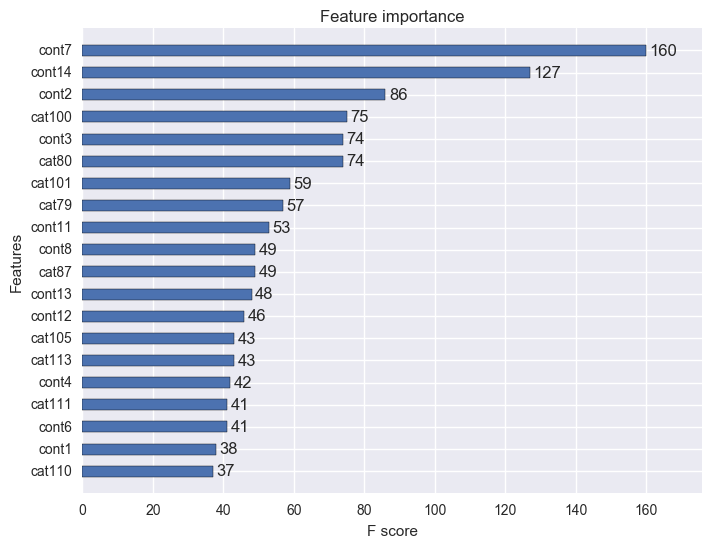

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

### 7. plot classfication trees (install graphviz first)

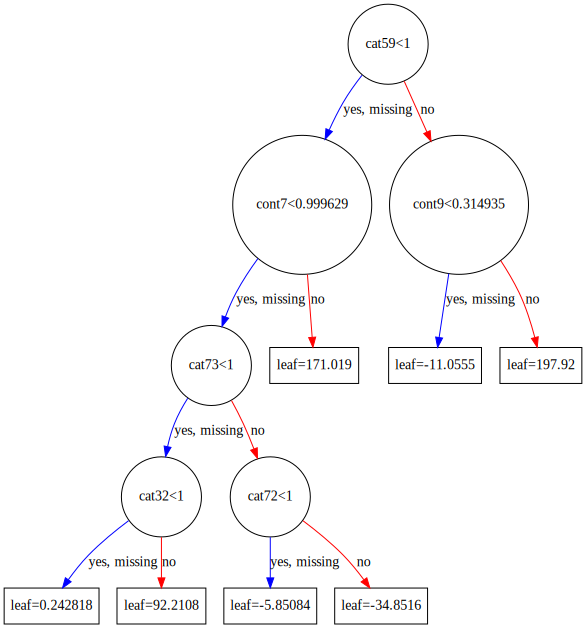

In [28]:
xgb.to_graphviz(booster = model, num_trees=100)

### 8. save and load model

In [29]:
model.save_model('XGBoost_1.model')                    # save model
del model
model = xgb.Booster(model_file = 'XGBoost_1.model')    # load model

### 9. make predictions

In [30]:
y_test = model.predict(X_test)   
submission = pd.DataFrame({'id':test_id, 'loss':y_test})
submission.head(10)

,id,loss
0,4,1845.435425
1,6,1940.387573
2,9,10264.169922
3,12,5529.886719
4,15,1148.303589
5,17,1951.747681
6,21,1910.919800
7,28,705.488037
8,32,2510.727051
9,43,2694.820312
